In [1]:
import pandas as pd
import numpy as np

In [2]:
# for processing
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# for bag-of-words
from sklearn import feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

## for train test split
import imblearn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JYM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JYM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\JYM\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')
print(cfpb_df.columns)
print(cfpb_df.shape)

C:\Users\JYM\AppData\Local\Temp/ipykernel_37400/889607879.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')


Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'dupi_id', 'dupi_len'],
      dtype='object')
(1300361, 23)


In [5]:
# cfpb_df[cfpb_df.dupi_len>3].sample()['dupi_id']

In [6]:
# cfpb_df[cfpb_df['Complaint ID'].isin([3726741,3726748,3751618,3751630])][['Consumer complaint narrative','Company']]

In [7]:
%%time
# Drop duplicates based on 'dupi_id' column
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

(1106587, 23)
Wall time: 457 ms


### See what we have with the TF-IDF vectorier

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase = False,ngram_range = (1,4))
vectorizer.fit(cfpb_df['Consumer complaint narrative'])
# This takes about 36GB RAM

TfidfVectorizer(lowercase=False, ngram_range=(1, 4))

In [9]:
# Extract the vocabulary and idf score
ngrams = vectorizer.get_feature_names_out()
# This takes about 31GB RAM

In [10]:
print(len(ngrams))

121189318


In [13]:
%%time
stop_words = set(stopwords.words('english'))
number_pattern = re.compile(r'^\d+|\d+$')  # match numbers at the start or end of a string
# regular expression to match repeating characters
repeating_chars_pattern = re.compile(r'^(.)\1*$')

filtered_vocab = {}

def clean_features(ngram):
    words = ngram.split()  # splits the n-gram into individual words
    # check if the n-gram starts/ends with a stop word or a number
    if (words[0] in stop_words or words[-1] in stop_words) or (number_pattern.match(words[0]) or number_pattern.match(words[-1]) or (repeating_chars_pattern.match(words[0]) or repeating_chars_pattern.match(words[-1]))):
        return False
    return True

ngrams_to_keep = [ngram for ngram in ngrams if clean_features(ngram)]

Wall time: 1min 35s


In [14]:
print(len(ngrams_to_keep))

46761914


### Round 2! Find proper document frequency thresholds

In [15]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt

# Creating a new vectorizer with your filtered vocabulary
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=ngrams_to_keep, ngram_range=(1,4))

# Fitting the vectorizer and transforming the narratives
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])

Wall time: 8min 14s


In [16]:
# Get the term frequencies
tf = np.sum(X, axis=0).A1

# Get the document frequencies
df = np.sum((X > 0), axis=0).A1

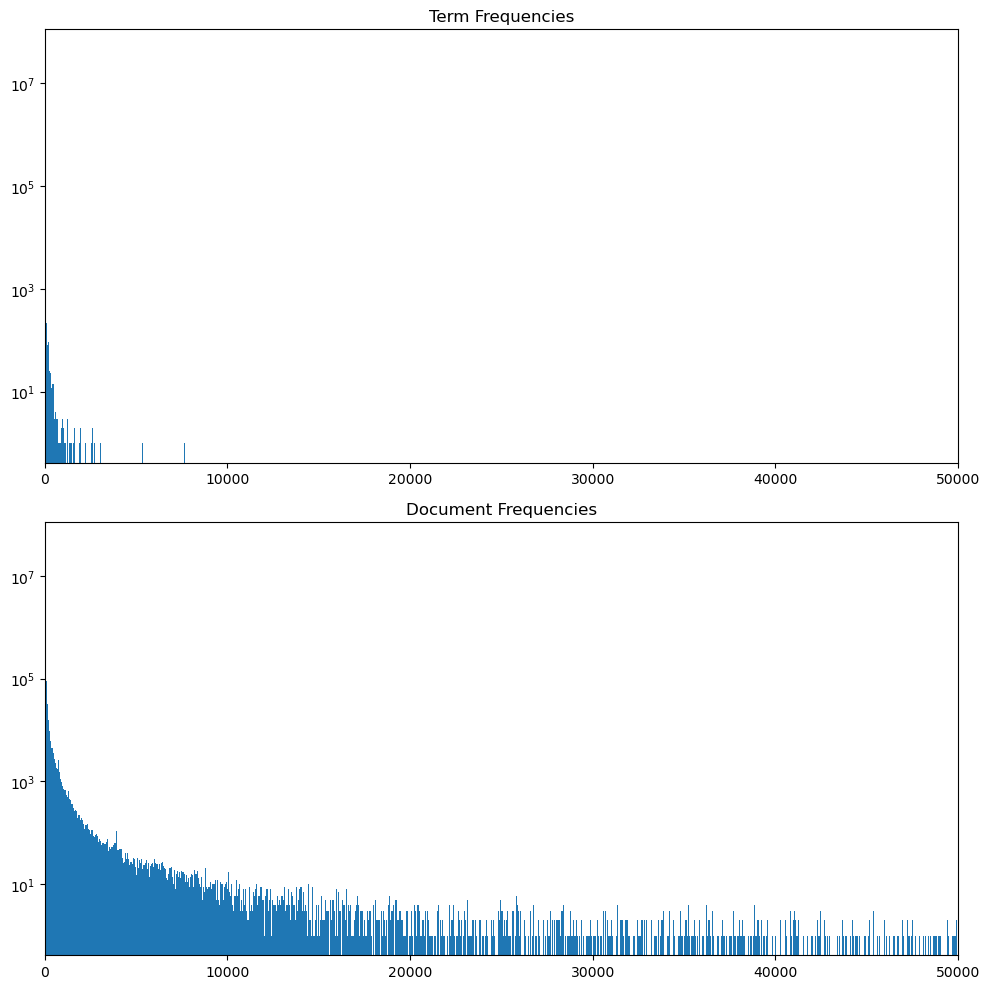

In [17]:
# Creating histograms for Term Frequencies and Document Frequencies
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].hist(tf, bins=10000)
axs[0].set_title('Term Frequencies')
axs[0].set_yscale('log')  # Using log scale for better visualization
axs[0].set_xlim([0, 50000])  # Set x-axis limit to 0-5000


axs[1].hist(df, bins=10000)
axs[1].set_title('Document Frequencies')
axs[1].set_yscale('log')  # Using log scale for better visualization
axs[1].set_xlim([0, 50000])  # Set x-axis limit to 0-5000


plt.tight_layout()
plt.show()

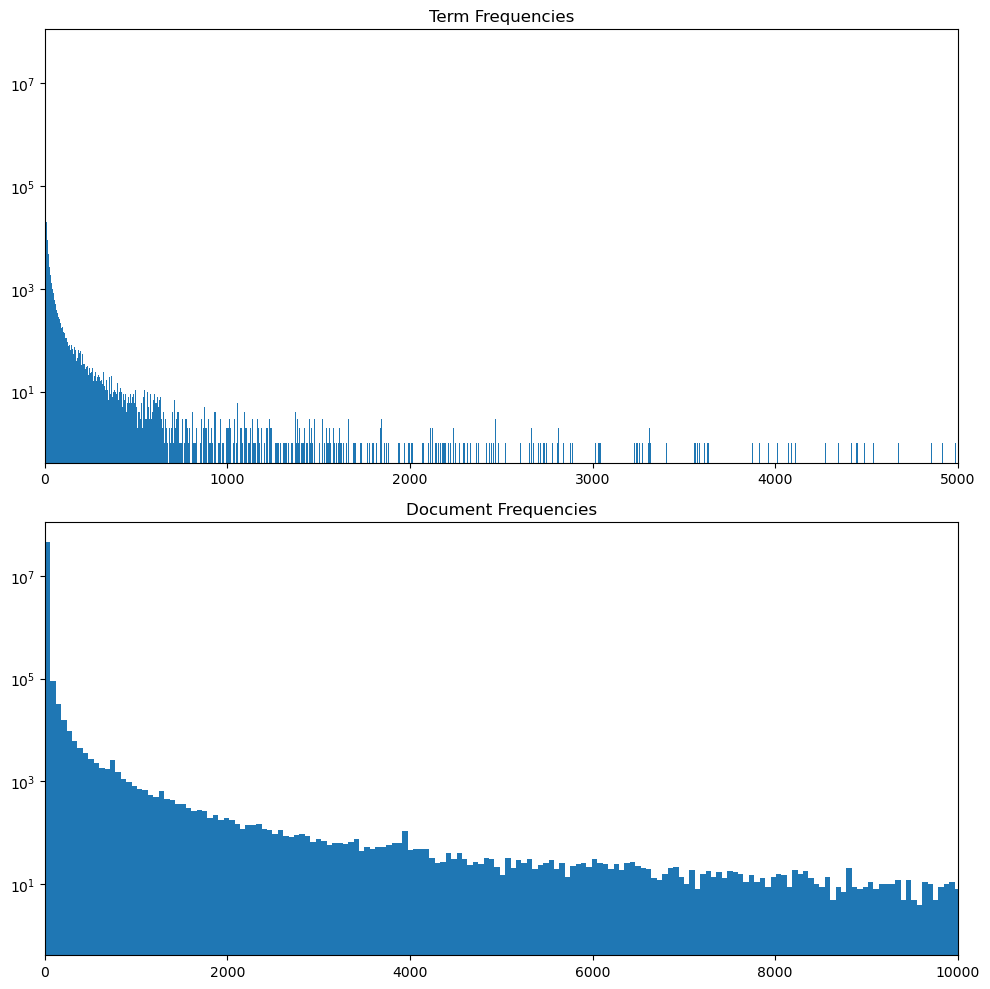

In [18]:
# Creating histograms for Term Frequencies and Document Frequencies
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].hist(tf, bins=10000)
axs[0].set_title('Term Frequencies')
axs[0].set_yscale('log')  # Using log scale for better visualization
axs[0].set_xlim([0, 5000])  # Set x-axis limit to 0-5000


axs[1].hist(df, bins=10000)
axs[1].set_title('Document Frequencies')
axs[1].set_yscale('log')  # Using log scale for better visualization
axs[1].set_xlim([0, 10000])  # Set x-axis limit to 0-5000


plt.tight_layout()
plt.show()

### Round 3! Further Reduce n-gram Features By through variance and correlation

In [38]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt

# Creating a new vectorizer with your filtered vocabulary, the max_df is actually 0.08 by calculation
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=ngrams_to_keep, ngram_range=(1,4), max_df=0.8, min_df=1500)

# Fitting the vectorizer and transforming the narratives
filtered_vectorizer.fit(cfpb_df['Consumer complaint narrative'])
# X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])

Wall time: 7min 46s


TfidfVectorizer(lowercase=False, max_df=0.8, min_df=1500, ngram_range=(1, 4),
                vocabulary=['A0', 'A0 15 USC', 'A0 would', 'A0 would like',
                            'A01', 'A01 15 USC', 'A02', 'A02 No',
                            'A02 No Valid', 'A02 No Valid Authorization', 'A1',
                            'A1 15 Code', 'A1 15 US', 'A1 15 US code',
                            'A1 621 A1', 'A1 623 A1', 'A1 A2', 'A1 A2 A3',
                            'A1 A2 A3 A4', 'A1 A2 in attached',
                            'A1 A2 signature', 'A1 A6', 'A1 A6 and A7',
                            'A1 Accuracy', 'A1 Accuracy and fairness',
                            'A1 Action', 'A1 Action Cash', 'A1 Collection',
                            'A1 Collection Service', 'A1 Collections', ...])

In [39]:
%%time
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])

Wall time: 8min 5s


In [40]:
new_ngrams = filtered_vectorizer.get_feature_names_out()

In [41]:
print(len(new_ngrams))

46761914


In [42]:
%%time
y = cfpb_df.Product.apply(lambda x: 1 if x=="Debt collection" else 0)

Wall time: 207 ms


In [43]:
y.value_counts()

0    911771
1    194816
Name: Product, dtype: int64

In [44]:
%%time
from sklearn.feature_selection import chi2

# Assume that `y` is your target variable
# `X` is your feature matrix (output of TfidfVectorizer)

# Compute chi2 scores and p-values for all features
chi2_scores, p_values = chi2(X, y)

Wall time: 10.4 s


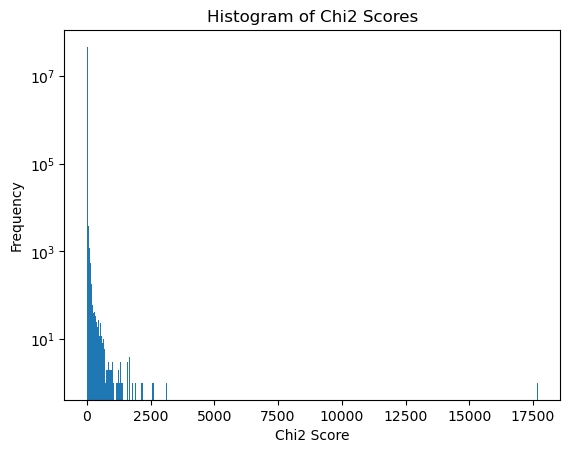

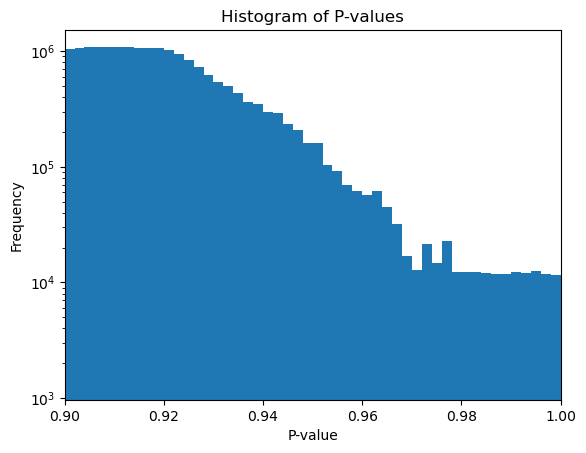

In [45]:
# Plot histogram of chi2 scores
plt.hist(chi2_scores, bins=500, log=True)
plt.title('Histogram of Chi2 Scores')
plt.xlabel('Chi2 Score')
plt.ylabel('Frequency')
plt.show()

# Optionally, plot histogram of p-values
plt.hist(p_values, bins=500, log=True)
plt.xlim([0.9, 1.0])
plt.title('Histogram of P-values')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

In [46]:
len([s for s in p_values if s>0.99])

60180

In [47]:
len([s for s in p_values if s>0.995])

30140

In [48]:
len([s for s in p_values if s>0.997])

17554

In [49]:
len([s for s in p_values if s>0.998])

11602

In [50]:
len([s for s in p_values if s>0.999])

5682

In [51]:
# use p-values to create a boolean mask
filtered_feature_names = np.array(filtered_vectorizer.get_feature_names_out())[p_values >= 0.997]

In [52]:
filtered_feature_names

array(['ABLE TO GIVE', 'ABOUT ANOTHER', 'ABOUT IT ALSO', ...,
       'yet the three bureaus', 'yet they tell', 'zip code and phone'],
      dtype=object)

In [53]:
len(filtered_feature_names)

17554

In [56]:
filtered_feature_names

array(['ABLE TO GIVE', 'ABOUT ANOTHER', 'ABOUT IT ALSO', ...,
       'yet the three bureaus', 'yet they tell', 'zip code and phone'],
      dtype=object)

### Round 4! Get the TF-IDF vectorizer ready

In [54]:
# Creating a new vectorizer with your filtered vocabulary, the max_df is actually 0.08 by calculation
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=filtered_feature_names, ngram_range=(1,4), max_df=0.8, min_df=1500)

# Fitting the vectorizer and transforming the narratives
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])

In [55]:
import pickle

# Save the trained vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(filtered_vectorizer, f)

In [ ]:
# Load the trained vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)